# Early fusion: Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/'
output_path = '../out/aus_egemaps'
# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load, prepare, and fuse data

#### Load

In [4]:
train_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_train.csv'))
train_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_train.csv'))

In [5]:
train_video_df

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,actor_id,file_id,target,group
0,0.130612,0.240045,0.0,0.000000,0.238713,0.238713,0.250000,0.141816,0.451565,0.0,...,0.363398,0.0,0.007299,0.092857,0.092857,0.258065,1,0,1,4
1,0.044369,0.260825,0.0,0.009934,0.095937,0.095937,0.142857,0.069400,0.354630,0.0,...,0.584047,0.0,0.007299,0.057143,0.057143,0.161290,1,1,1,4
2,0.064720,0.237358,0.0,0.009934,0.110045,0.110045,0.285714,0.117179,0.324758,0.0,...,0.380347,0.0,0.029197,0.039286,0.039286,0.096774,1,2,1,4
3,0.102294,0.225245,0.0,0.000000,0.173815,0.173815,0.071429,0.068794,0.339125,0.0,...,0.303059,0.0,0.014599,0.035714,0.035714,0.129032,1,3,1,4
4,0.122895,0.296350,0.0,0.000000,0.174379,0.174379,0.178571,0.126430,0.469950,0.0,...,0.255539,0.0,0.058394,0.064286,0.064286,0.225806,1,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.051192,0.192379,0.0,0.026490,0.081264,0.081264,0.321429,0.093234,0.390645,0.0,...,0.358930,0.0,0.000000,0.569286,0.569286,0.161290,10,1255,17,5
1255,0.026198,0.275834,0.0,0.009934,0.028217,0.028217,0.535714,0.050406,0.353327,0.0,...,0.507585,0.0,0.021898,0.107143,0.107143,0.258065,10,1256,17,5
1256,0.081445,0.338825,0.0,0.003311,0.079007,0.079007,0.464286,0.118401,0.490531,0.0,...,0.551471,0.0,0.007299,0.078571,0.078571,0.322581,10,1257,17,5
1257,0.042385,0.270673,0.0,0.004967,0.070542,0.070542,0.214286,0.047610,0.394670,0.0,...,0.358960,0.0,0.000000,0.328571,0.328571,0.225806,10,1258,17,5


In [6]:
train_video_df.actor_id.value_counts()

10    126
9     126
8     126
7     126
6     126
4     126
3     126
2     126
1     126
5     125
Name: actor_id, dtype: int64

In [7]:
train_audio_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,actor_id,file_id,target,group
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.330578,0.037114,0.117179,0.047826,0.088380,0.731259,1,0,1,4
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.264558,0.055237,0.089090,0.057971,0.000000,0.725443,1,1,1,4
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.344937,0.038350,0.090084,0.050725,0.049834,0.742759,1,2,1,4
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.337101,0.039662,0.074729,0.045894,0.040150,0.789177,1,3,1,4
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.161629,0.090247,0.320940,0.045894,0.058668,0.764986,1,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.455030,0.051548,0.459465,0.432665,0.428898,0.042556,0.136981,0.009610,0.209519,0.008897,...,0.192274,0.065019,0.064878,0.086957,0.127309,0.693686,10,1255,17,5
1255,0.220083,0.513768,0.031770,0.317742,0.347561,0.422764,0.358086,0.306875,0.228330,0.014988,...,0.396111,0.023316,0.090696,0.077122,0.096082,0.760948,10,1256,17,5
1256,0.270762,0.520014,0.024084,0.363869,0.372689,0.462329,0.259245,0.118235,0.245574,0.060586,...,0.376332,0.022740,0.107705,0.091938,0.147996,0.786001,10,1257,17,5
1257,0.450948,0.089263,0.419079,0.440764,0.442042,0.104093,0.162826,0.065396,0.205408,0.005887,...,0.155720,0.063989,0.077539,0.134058,0.268334,0.721901,10,1258,17,5


In [8]:
train_audio_df.actor_id.value_counts()

10    126
9     126
8     126
7     126
6     126
4     126
3     126
2     126
1     126
5     125
Name: actor_id, dtype: int64

#### Fuse data

In [9]:
# Fuse training data (audio + video)
train_audio_id_df_tmp = train_audio_df.drop(columns=['target','actor_id','group'])              # Drop target, actor_id, and group from the audio dataframe, since they are already in the video dataframe
train_df = train_audio_id_df_tmp.merge(train_video_df, how='left', on='file_id')                # Merge on file_id
train_df = train_df[[c for c in train_df if c not in ['file_id', 'actor_id', 'group','target']]
                    + ['file_id', 'actor_id', 'group','target']]                                # Reorder columns so file_id, actor_id, and target are at the end of the dataframe
train_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,file_id,actor_id,group,target
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.363398,0.0,0.007299,0.092857,0.092857,0.258065,0,1,4,1
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.584047,0.0,0.007299,0.057143,0.057143,0.161290,1,1,4,1
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.380347,0.0,0.029197,0.039286,0.039286,0.096774,2,1,4,1
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.303059,0.0,0.014599,0.035714,0.035714,0.129032,3,1,4,1
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.255539,0.0,0.058394,0.064286,0.064286,0.225806,4,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.455030,0.051548,0.459465,0.432665,0.428898,0.042556,0.136981,0.009610,0.209519,0.008897,...,0.358930,0.0,0.000000,0.569286,0.569286,0.161290,1255,10,5,17
1255,0.220083,0.513768,0.031770,0.317742,0.347561,0.422764,0.358086,0.306875,0.228330,0.014988,...,0.507585,0.0,0.021898,0.107143,0.107143,0.258065,1256,10,5,17
1256,0.270762,0.520014,0.024084,0.363869,0.372689,0.462329,0.259245,0.118235,0.245574,0.060586,...,0.551471,0.0,0.007299,0.078571,0.078571,0.322581,1257,10,5,17
1257,0.450948,0.089263,0.419079,0.440764,0.442042,0.104093,0.162826,0.065396,0.205408,0.005887,...,0.358960,0.0,0.000000,0.328571,0.328571,0.225806,1258,10,5,17


#### Shuffle data

In [10]:
from sklearn.utils import shuffle

train_shuffled_df = shuffle(train_df, random_state=seed)
train_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,file_id,actor_id,group,target
315,0.240379,0.614553,0.089265,0.219347,0.284260,0.280270,0.303624,0.200022,0.262954,0.033284,...,0.304999,0.0,0.043796,0.065714,0.065714,0.354839,315,3,3,9
1116,0.428243,0.121044,0.397641,0.397569,0.437531,0.122617,0.148100,0.015786,0.218510,0.011256,...,0.516488,0.0,0.007299,0.057143,0.057143,0.096774,1117,9,4,15
986,0.499724,0.243378,0.437738,0.420981,0.586214,0.260613,0.142826,0.018867,0.205943,0.003317,...,0.360287,0.0,0.036496,0.053571,0.053571,0.258065,987,8,5,14
1066,0.294653,0.605192,0.026334,0.314250,0.475608,0.586494,0.137131,0.002755,0.226926,0.000000,...,0.539384,0.0,0.021898,0.062857,0.062857,0.161290,1067,9,4,9
323,0.154184,0.620439,0.076768,0.134368,0.172950,0.157283,0.179695,0.035599,0.277163,0.124323,...,0.384070,0.0,0.014599,0.054286,0.054286,0.354839,323,3,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.800665,0.175227,0.745947,0.790104,0.808547,0.188162,0.173931,0.011665,0.205735,0.023853,...,0.468963,0.0,0.007299,0.045714,0.045714,0.161290,141,2,1,3
1048,0.339490,0.457571,0.146215,0.395539,0.453824,0.425043,0.180069,0.018150,0.230690,0.016112,...,0.380418,0.0,0.000000,0.318571,0.318571,0.129032,1049,9,4,6
752,0.628904,0.354822,0.665858,0.633961,0.696183,0.139788,0.381234,0.154791,0.274983,0.100322,...,0.272443,0.0,0.051095,0.046429,0.046429,0.354839,753,6,2,17
543,0.663620,0.149773,0.618283,0.661143,0.654561,0.141982,0.142250,0.015549,0.208364,0.004063,...,0.355894,0.0,0.036496,0.102143,0.102143,0.483871,543,5,3,6


#### Other functions

In [11]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([18,18])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_eng_id_to_emotion_num.keys()), list(emotion_eng_id_to_emotion_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')        

## Early Fusion Pipelines

### Elastic Net

In [12]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,5, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator          = elasticnet, 
                   param_grid         = parameters,
                   scoring            = 'roc_auc_ovo_weighted',
                   cv                 = logo.split(X=X,groups=groups),
                   verbose            = 1,
                   n_jobs             = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_elastic_net_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_elastic_net.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_elastic_net.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 76.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 89.0min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 100.6min finished


SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=2500,
              n_iter_no_change=50, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=27, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
329,3.573310,0.161904,0.238084,0.004585,0.001,balanced,0.15,log,2500,50,...,27,"{'alpha': 0.001, 'class_weight': 'balanced', '...",0.894815,0.857480,0.866282,0.859931,0.852526,0.866207,0.014974,1
337,4.166642,0.280338,0.379580,0.188087,0.001,balanced,0.25,log,2500,50,...,27,"{'alpha': 0.001, 'class_weight': 'balanced', '...",0.896903,0.856663,0.866204,0.858595,0.852630,0.866199,0.015973,2
333,3.885950,0.494062,0.276943,0.057666,0.001,balanced,0.2,log,2500,50,...,27,"{'alpha': 0.001, 'class_weight': 'balanced', '...",0.895282,0.857065,0.866515,0.859659,0.851437,0.865992,0.015426,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9633614756821499
AUC_std (train): 0.0023751396576140683
AUC_avg (validation): 0.8662068920998601
AUC_std (validation): 0.014974343682690563


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


UAR_avg (train): 0.7112784733089897
UAR_std (train): 0.018683540802529847
UAR_avg (validation): 0.3383079157588962
UAR_std (validation): 0.048233783056516946


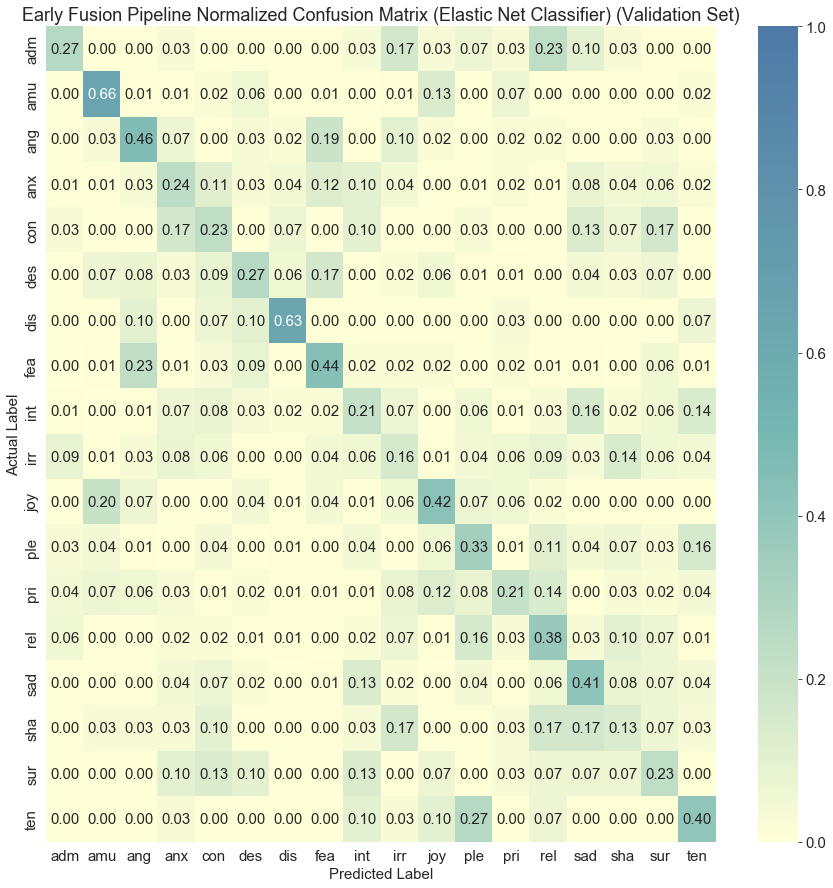

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_elastic_net.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,           
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Elastic Net Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_elastic_net.svg',
                      report    = True
                     )

### kNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_knn_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_knn.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_knn.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 14.5min


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=146, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 8145 out of 8145 | elapsed: 16.8min finished


In [14]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1477,0.022444,0.012553,0.452203,0.032870,kd_tree,30,manhattan,-1,146,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",0.877853,0.810166,0.829311,0.841743,0.807903,0.833395,0.025504,1
934,0.007025,0.000677,0.425937,0.024567,brute,30,manhattan,-1,146,uniform,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",0.877853,0.810166,0.829311,0.841743,0.807903,0.833395,0.025504,1
1115,0.017955,0.000539,0.491026,0.012979,kd_tree,10,manhattan,-1,146,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'met...",0.877853,0.810166,0.829311,0.841743,0.807903,0.833395,0.025504,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.8764306340096268
AUC_std (train): 0.005700775158328284
AUC_avg (validation): 0.8333951725974179
AUC_std (validation): 0.02550425259531258


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


UAR_avg (train): 0.28175969396626677
UAR_std (train): 0.01234220699069493
UAR_avg (validation): 0.24898329702251268
UAR_std (validation): 0.03280549514447308


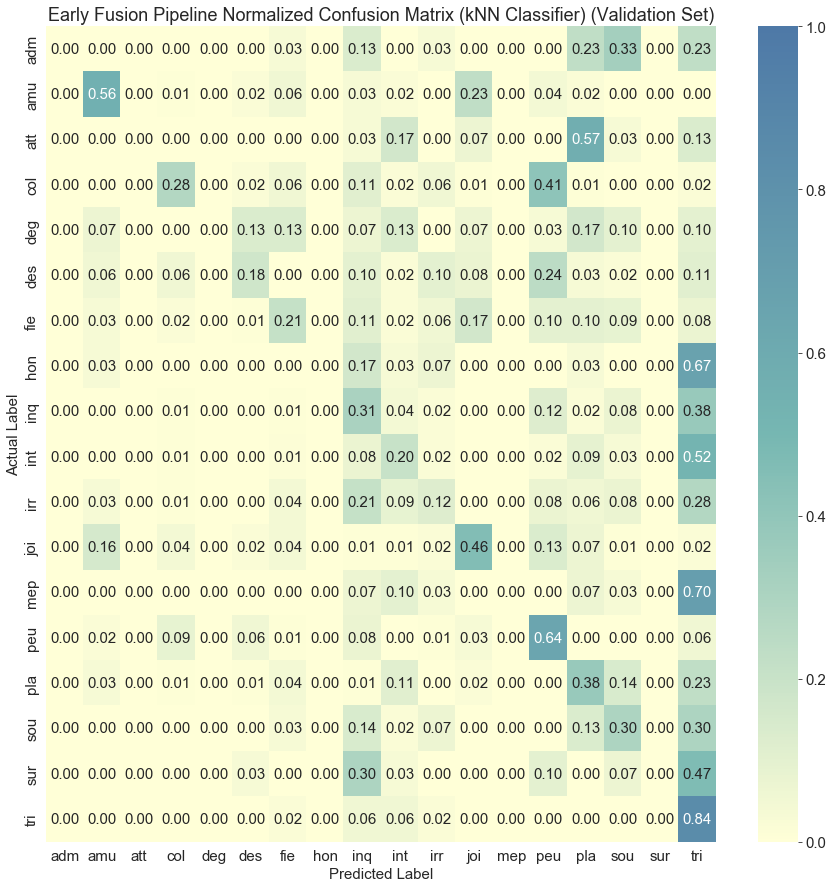

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_knn.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (kNN Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_knn.svg'
                     )

### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_tree_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_tree.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_tree.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=50, max_features=97,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.1,
                       min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=27,
                       splitter='random')


In [30]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2838,0.010947,0.001295,0.271155,0.006316,random,27,0.1,0.1,97,30,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.784333,0.724239,0.700877,0.730846,0.71968,0.731995,0.028003,1
4988,0.009841,0.001261,0.272115,0.003323,random,27,0.2,0.1,97,30,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.784333,0.724239,0.700877,0.730846,0.71968,0.731995,0.028003,1
2118,0.009947,0.000764,0.279881,0.007340,random,27,0.1,0.1,97,50,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.784333,0.724239,0.700877,0.730846,0.71968,0.731995,0.028003,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


AUC_avg (train): 0.7771903384953185
AUC_std (train): 0.009354146326543649
AUC_avg (validation): 0.7319950141519689
AUC_std (validation): 0.028002734246928743
UAR_avg (train): 0.21203703703703702
UAR_std (train): 0.0144716558080249
UAR_avg (validation): 0.16111111111111112
UAR_std (validation): 0.04265070288919677


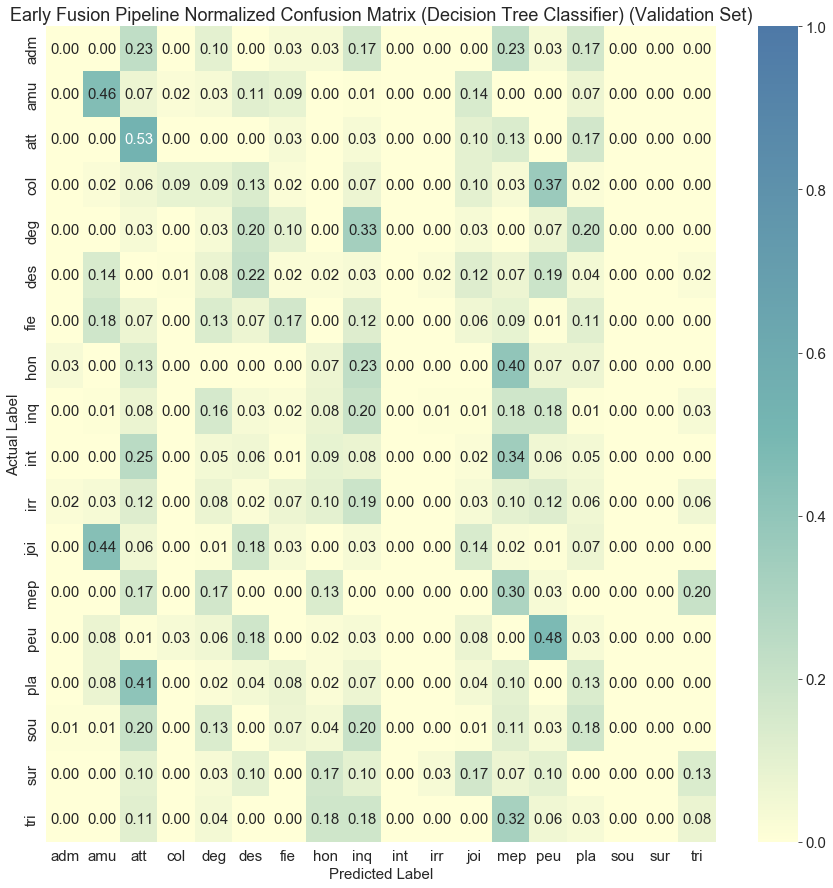

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_tree.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Decision Tree Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_tree.svg'
                     )

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_rf_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_rf.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_rf.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 75.3min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 93.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 132.2min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 154.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 177.4min
[Parallel(n_jobs=-1)]: Done 11242 tasks   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=420,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3098,4.462210,0.118732,0.815590,0.083413,27,-1,420,5,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.897746,0.834189,0.842791,0.853045,0.847300,0.855014,0.022237,1
2745,4.587157,0.105773,0.671026,0.095964,27,-1,415,2,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.897124,0.834591,0.842419,0.853395,0.847352,0.854976,0.021956,2
4186,4.646906,0.463587,0.767666,0.078967,27,-1,420,2,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.897448,0.834189,0.842717,0.853045,0.847300,0.854940,0.022131,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9997606845927731
AUC_std (train): 4.820589210089055e-05
AUC_avg (validation): 0.8550143566874798
AUC_std (validation): 0.022237263188291025


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


UAR_avg (train): 0.995216049382716
UAR_std (train): 0.0016476972611159275
UAR_avg (validation): 0.3228395061728395
UAR_std (validation): 0.07616893761141144


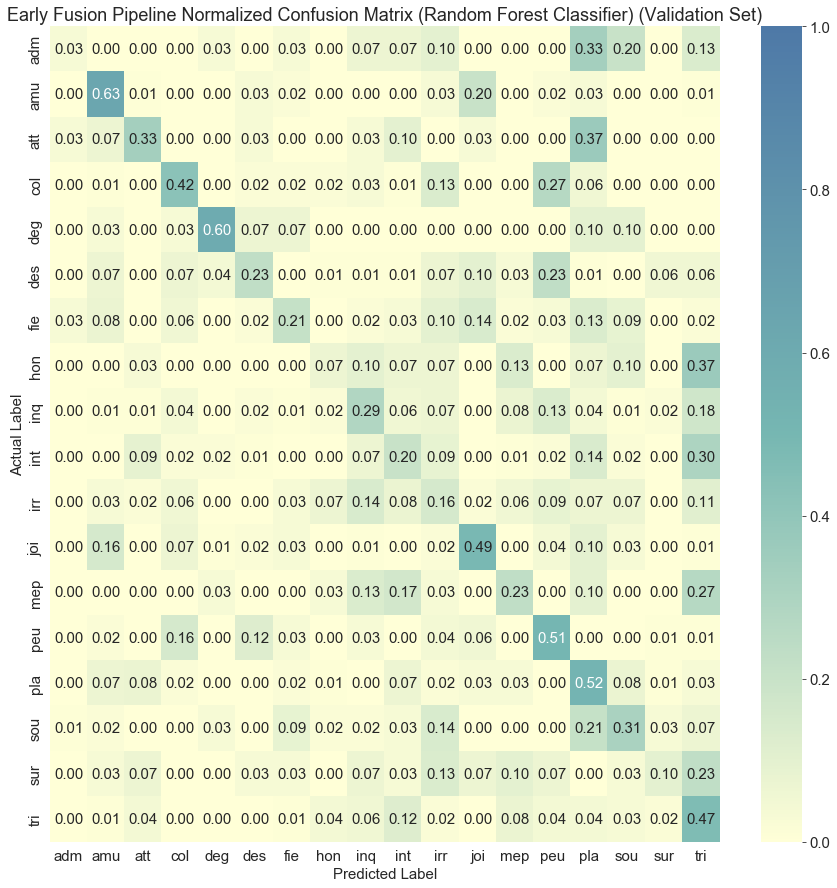

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_rf.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Random Forest Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_rf.svg'
                     )